<a href="https://colab.research.google.com/github/amindadgar/xray-image-explanations/blob/main/xray_image_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchxrayvision
!pip install lime
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.0 MB 1.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 28.2 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=73610f34ff6446ec1513baf5287b66a869e425ff518bbbf7e4de3c813aaf889e
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 12.8 MB/s 


In [2]:
!wget https://raw.githubusercontent.com/mlmed/torchxrayvision/master/scripts/process_image.py

--2022-12-28 17:28:20--  https://raw.githubusercontent.com/mlmed/torchxrayvision/master/scripts/process_image.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2058 (2.0K) [text/plain]
Saving to: ‘process_image.py’

process_image.py    100%[===================>]   2.01K  --.-KB/s    in 0s      

2022-12-28 17:28:20 (27.5 MB/s) - ‘process_image.py’ saved [2058/2058]



In [3]:
!python batch_download_zips.py

downloadingimages_01.tar.gz...
Download complete. Please check the checksums


In [ ]:
!tar -xvzf images_01.tar.gz

In [5]:
!python process_image.py images/00000001_000.png

If this fails you can run `wget https://github.com/mlmed/torchxrayvision/releases/download/v1/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt -O /root/.torchxrayvision/models_data/nih-pc-chex-mimic_ch-google-openi-kaggle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt`
[██████████████████████████████████████████████████]
{'preds': {'Atelectasis': 0.4519389,
           'Cardiomegaly': 0.74161935,
           'Consolidation': 0.18644723,
           'Edema': 0.19969514,
           'Effusion': 0.3413773,
           'Emphysema': 0.5015446,
           'Enlarged Cardiomediastinum': 0.37346685,
           'Fibrosis': 0.5102874,
           'Fracture': 0.5008092,
           'Hernia': 0.0105754705,
           'Infiltration': 0.40493545,
           'Lung Lesion': 0.14847147,
           'Lung Opacity': 0.18765913,
           'Mass': 0.11758584,
           'Nodule': 0.50317943,
           'Pleural_Thickening': 0.51538575,
           'Pneumonia'

In [7]:
import matplotlib.pyplot as plt
import torch
import numpy as np

In [7]:
torch.cuda.is_available()

True

In [3]:
import torchxrayvision as xrv
import skimage, torch, torchvision

# Prepare the image:
img = skimage.io.imread("images/00000001_000.png")
img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range
img = img[None, :, :]

# transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(224)])
transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop()])

img = transform(img)
img = torch.from_numpy(img).unsqueeze(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)

# Load model and process image
model = xrv.models.DenseNet(weights="densenet121-res224-all")
model.to(device)
preds = model(img)
output = {}
output["preds"] = dict(zip(xrv.datasets.default_pathologies,preds[0].detach().cpu().numpy()))

output

{'preds': {'Atelectasis': 0.4519393,
  'Consolidation': 0.18644758,
  'Infiltration': 0.40493643,
  'Pneumothorax': 0.10958174,
  'Edema': 0.1996956,
  'Emphysema': 0.5015446,
  'Fibrosis': 0.51028746,
  'Effusion': 0.3413772,
  'Pneumonia': 0.44131783,
  'Pleural_Thickening': 0.51538587,
  'Cardiomegaly': 0.7416194,
  'Nodule': 0.50317943,
  'Mass': 0.11758613,
  'Hernia': 0.010575576,
  'Lung Lesion': 0.14847197,
  'Fracture': 0.5008092,
  'Lung Opacity': 0.1876597,
  'Enlarged Cardiomediastinum': 0.37346807}}

In [9]:
def predict_img(images_batch):

  ## the input is a gray image repeated in 3 color channels
  ## so one of them is choosen

  # img = image[None, :, :, 0]
  img = images_batch[:, :, :, 0]
  img = img.astype(np.float)
  ## clip the values more than 255
  img = np.where(img > 255, 255, img)
  img = xrv.datasets.normalize(img, 255) # convert 8-bit image to [-1024, 1024] range

  transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop()])

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  ## transforming the image batches
  img_arr = []
  for img_values in img:
    img_squeezed = img_values[None, :, :]
    img_arr.append(transform(img_squeezed))
  
  ## getting the transformed images back to img variable
  img = np.array(img_arr)
  img = torch.from_numpy(img)
  img = img.to(device)

  # Load model and process image
  model = xrv.models.DenseNet(weights="densenet121-res224-all")
  model.to(device)
  preds = model(img)

  return preds.detach().cpu().numpy()

# Using Capturn library for explanations 

In [31]:
from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap


In [11]:
img.shape

torch.Size([1, 1, 1024, 1024])

## Integrated Gradient
This method seems to need huge computation resource and every time we ran it, we weren't able to get an explanation (colab crashed) 

In [34]:
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(img, target=10, n_steps=200)

OutOfMemoryError: ignored

In [ ]:
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)

## Occlusion-based attribution

In [35]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(img,
                                       strides = (3, 8, 8),
                                       target=10,
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)

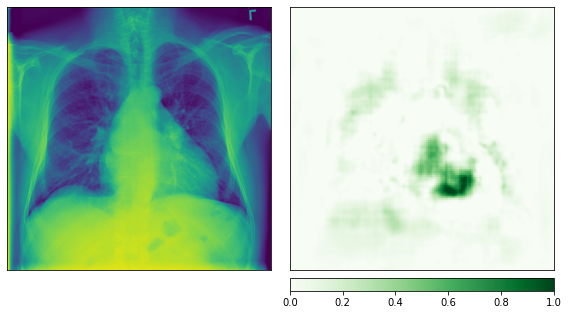

In [36]:
# _ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      # np.transpose(img.squeeze().cpu().detach().numpy(), (1,2,0)),
_ = viz.visualize_image_attr_multiple(attributions_occ.cpu().detach().numpy().reshape((1024, 1024, 1)),
                                      img.cpu().detach().numpy().reshape((1024, 1024, 1)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                     )

## GradientShap

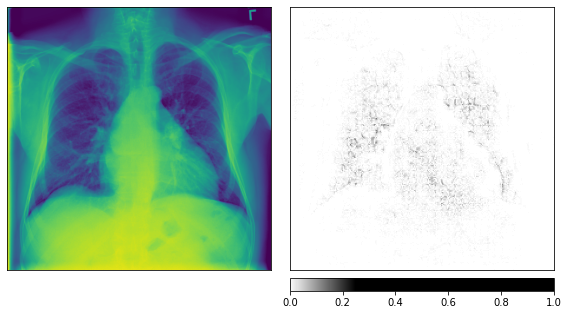

In [40]:
gradienShape = GradientShap(model)

rand_img_dist = torch.cat([img * 0, img * 1])
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
 

attributions_gs = gradienShape.attribute(img,  
                                       target=10,
                                       n_samples=50,
                                       baselines=rand_img_dist,
                                       stdevs=0.0001,
                                       )
_ = viz.visualize_image_attr_multiple(attributions_gs.cpu().detach().numpy().reshape((1024, 1024, 1)),
                                      img.cpu().detach().numpy().reshape((1024, 1024, 1)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

## DeepLift

# LIME method Explanation

In [ ]:
from lime import lime_image
import numpy as np

In [ ]:
img = img.detach().cpu().numpy()
img_channel_added = np.repeat(img, 3).reshape((1024, 1024, 3))
img_channel_added.shape

(1024, 1024, 3)

In [ ]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_channel_added.astype(np.double), 
                                         predict_img, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000) # number of images that will be sent to classification function

  0%|          | 0/1000 [00:00<?, ?it/s]

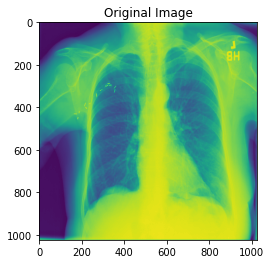

In [ ]:
plt.title("Original Image")
plt.imshow(img[0, 0, :, :])
plt.show()

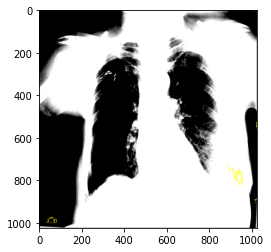

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

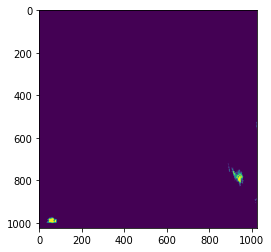

In [ ]:
plt.imshow(mask)

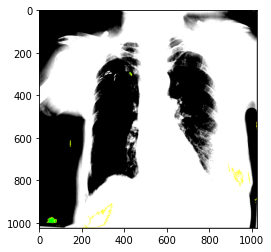

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2, cmap='gray')
plt.show()

In [ ]:
explanation.score

0.9999991583217043

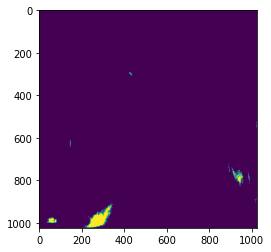

In [ ]:
plt.imshow(mask)